<!-- ![image.png](attachment:image.png) -->

[![ebac_logo-data_science.png](https://raw.githubusercontent.com/rhatiro/Curso_EBAC-Profissao_Cientista_de_Dados/main/ebac-course-utils/media/logo/ebac_logo-data_science.png)](https://github.com/rhatiro/Curso_EBAC-Profissao_Cientista_de_Dados)
<!-- <img src="https://raw.githubusercontent.com/rhatiro/Curso_EBAC-Profissao_Cientista_de_Dados/main/ebac-course-utils/media/logo/ebac_logo-data_science.png" alt="ebac_logo-data_science"> -->

---

<!-- # **Profissão: Cientista de Dados** -->
### **Módulo 35** | Regressão IV | Exercício

**Aluno:** [Roberto Hatiro Nishiyama](https://www.linkedin.com/in/rhatiro/)<br>
**Data:** 16 de Setembro de 2024.

---

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelo de previsão de renda que você fez para esta base. 

- Substitua *missings* pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [4]:
# Importando bibliotecas necessárias para o projeto

import numpy as np      # Biblioteca para operações matemáticas e manipulação de arrays
import pandas as pd     # Biblioteca para manipulação e análise de dados (DataFrames)

import matplotlib.pyplot as plt  # Biblioteca para criar gráficos
import seaborn as sns            # Biblioteca para visualização de dados mais avançada, integrada ao Matplotlib

from sklearn.model_selection import train_test_split  # Função para dividir os dados em treino e teste

import statsmodels.api as sm           # Biblioteca para criar modelos estatísticos
import statsmodels.formula.api as smf  # Interface para criar modelos estatísticos usando fórmulas

from scipy.interpolate import interp1d  # Função para interpolação de dados (preenchimento de valores)

from sklearn.metrics import r2_score  # Função para calcular o coeficiente de determinação (R²), avaliando a qualidade do modelo

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif  
# Função para calcular o Fator de Inflação da Variância (VIF), usada para detectar multicolinearidade entre variáveis


In [5]:
# Lendo o arquivo CSV com os dados e removendo a coluna 'index' que não é necessária
df = pd.read_csv(filepath_or_buffer="./Dados/previsao_de_renda_II.csv").drop(columns="index")

# Exibindo informações sobre o DataFrame, como tipos de dados e quantidade de valores nulos
df.info()

# Mostrando o conteúdo do DataFrame
df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          624240 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(2), object(8)
memory usage: 74.4+ MB


,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,F,N,S,1,Assalariado,Superior completo,Casado,Casa,29,8.665753,3.0,2930.40
749996,2016-03-01,F,N,S,0,Pensionista,Superior completo,Casado,Casa,65,NaN,2.0,4084.37
749997,2016-03-01,F,N,S,0,Assalariado,Superior completo,Casado,Casa,33,10.969863,2.0,4339.66
749998,2016-03-01,F,S,S,1,Empresário,Superior completo,União,Casa,28,8.219178,3.0,9159.49


---

In [7]:
def amostra(data: pd.DataFrame, column: str, perc: float = 1, seed: int = None) -> pd.DataFrame:
    """
    Retorna uma amostra de um DataFrame de acordo com o parâmetro de porcentagem definido.

    Parameters:
    - data (pd.DataFrame): O DataFrame a ser amostrado.
    - column (str): O nome da coluna usada para agrupar os dados antes de amostrar.
    - perc (float): Porcentagem da amostra a ser retornada (deve estar entre 0 e 1). O padrão é 1 (ou seja, 100%).
    - seed (int, optional): Semente para o gerador de números aleatórios, garantindo reprodutibilidade.

    Returns:
    - pd.DataFrame: Um novo DataFrame contendo a amostra dos dados.

    Raises:
    - ValueError: Se o parâmetro perc não estiver entre 0 e 1.
    - KeyError: Se a coluna especificada não existir no DataFrame.

    Examples:
    >>> df = pd.DataFrame({
    >>>     'A': ['foo', 'foo', 'bar', 'bar', 'foo'],
    >>>     'B': [1, 2, 3, 4, 5]
    >>> })
    >>> amostra(df, 'A', perc=0.5, seed=42)
    """
    
    # Verifica se a porcentagem está entre 0 e 1. Caso contrário, gera um erro
    if not (0 < perc <= 1):
        raise ValueError("O parâmetro perc deve estar entre 0 e 1.")

    # Verifica se a coluna especificada existe no DataFrame. Caso não exista, gera um erro
    if column not in data.columns:
        raise KeyError(f"A coluna '{column}' não existe no DataFrame.")

    # Realiza a amostragem dos dados agrupados pela coluna especificada
    # O 'frac=perc' define a fração de dados a ser amostrada, e 'random_state=seed' garante a reprodutibilidade
    new_df = (data.set_index(keys=column)
                  .groupby(by=column, group_keys=False)
                  .apply(lambda x: x.sample(frac=perc, random_state=seed), 
                         include_groups=False)
                  .reset_index())
    
    # Exibe o tamanho dos DataFrames antes e depois da amostragem
    print(f"Original DataFrame size:\n{data.groupby(by=column).size()}\nTotal para 100% dos dados: {len(data)} linhas\n")
    print(f"New DataFrame size:\n{new_df.groupby(by=column).size()}\nTotal para {perc:.1%} dos dados: {len(new_df)} linhas\n")
    
    return new_df


In [8]:
# Criando uma cópia do DataFrame original para preservar os dados originais
df_ = df.copy()

# Criando uma nova coluna 'renda_log' com a transformação logarítmica da coluna 'renda'
df_.loc[:, "renda_log"] = np.log(df_.renda)

# Chamando a função 'amostra' para pegar 1% dos dados, agrupando pela coluna 'data_ref' e utilizando uma semente para reprodutibilidade
df_ = amostra(data=df_, column="data_ref", perc=.01, seed=420)

# Exibindo o DataFrame resultante
df_


Original DataFrame size:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
dtype: int64
Total para 100% dos dados: 750000 linhas

New DataFrame size:
data_ref
2015-01-01    500
2015-02-01    500
2015-03-01    500
2015-04-01    500
2015-05-01    500
2015-06-01    500
2015-07-01    500
2015-08-01    500
2015-09-01    500
2015-10-01    500
2015-11-01    500
2015-12-01    500
2016-01-01    500
2016-02-01    500
2016-03-01    500
dtype: int64
Total para 1.0% dos dados: 7500 linhas



,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log
0,2015-01-01,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,9935.03,9.203822
1,2015-01-01,F,S,S,0,Empresário,Médio,Casado,Casa,47,5.528767,2.0,10665.10,9.274732
2,2015-01-01,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,12.526027,1.0,15899.37,9.674035
3,2015-01-01,M,S,S,0,Assalariado,Superior completo,Separado,Casa,40,1.945205,1.0,3442.69,8.144008
4,2015-01-01,F,N,N,0,Empresário,Médio,Casado,Governamental,50,4.676712,2.0,1619.86,7.390095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,2016-03-01,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,32,0.841096,1.0,1263.60,7.141720
7496,2016-03-01,F,N,S,0,Empresário,Superior completo,Solteiro,Casa,50,6.687671,1.0,850.94,6.746342
7497,2016-03-01,F,S,N,1,Servidor público,Superior completo,Casado,Casa,38,14.712329,3.0,18671.61,9.834759
7498,2016-03-01,F,S,N,0,Assalariado,Superior completo,Solteiro,Casa,55,2.800000,1.0,638.82,6.459623


In [9]:
# Preenchendo os valores nulos da coluna 'tempo_emprego' com a média dos valores dessa mesma coluna
df_.fillna(value={"tempo_emprego": df_.tempo_emprego.mean()}, inplace=True)

# Exibindo a contagem de valores nulos em cada coluna após o preenchimento
df_.isna().sum()


data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
renda_log                0
dtype: int64

In [10]:
# Dividindo o DataFrame em conjuntos de treino e teste, com 80% para treino e 20% para teste
# A semente (random_state=420) garante que a divisão seja reprodutível
df_train, df_test = train_test_split(df_, test_size=.2, random_state=420)

# Exibindo as dimensões (número de linhas e colunas) dos DataFrames de treino e teste
print(df_train.shape)  # Mostra o tamanho do conjunto de treino
print(df_test.shape)   # Mostra o tamanho do conjunto de teste


(6000, 14)
(1500, 14)


---

In [12]:
# Criando e ajustando um modelo de regressão linear usando a fórmula 'renda_log ~ tempo_emprego'
# O modelo é treinado com o DataFrame de treino (df_train)
# O método .fit() ajusta o modelo aos dados e .summary() exibe um resumo dos resultados do modelo
smf.ols(formula="renda_log ~ tempo_emprego", data=df_train).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     3414.
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:50:08   Log-Likelihood:                -8676.6
No. Observations:                6000   AIC:                         1.736e+04
Df Residuals:                    5998   BIC:                         1.737e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.0319      0.022    369.885      0.000       7.989       8.074
tempo_emprego     0.1307      0.002     58.434      0.000       0.126       0.135
==============================================================================
Omnibus:                       39.691   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.249
Skew:                           0.039   Prob(JB):                     7.34e-07
Kurtosis:                       2.673   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
%%time

# Aplicando a suavização LOWESS (Locally Weighted Scatterplot Smoothing) para ajustar uma curva aos dados
# 'endog' é a variável dependente (renda_log) e 'exog' é a variável independente (tempo_emprego)
# A função sm.nonparametric.lowess realiza o ajuste e armazena o resultado na variável 'lowess'
lowess = sm.nonparametric.lowess(endog=df_train.renda_log, exog=df_train.tempo_emprego)


CPU times: user 977 ms, sys: 15.5 ms, total: 993 ms
Wall time: 1.01 s


In [14]:
%%time

# Criando uma função de interpolação 1D usando os dados ajustados pelo LOWESS
# 'x' são os valores da variável independente e 'y' são os valores da variável dependente ajustados
# 'bounds_error=False' permite extrapolação fora do intervalo dos dados fornecidos
f_ = interp1d(x=lowess[:, 0], y=lowess[:, 1], bounds_error=False)


CPU times: user 875 μs, sys: 485 μs, total: 1.36 ms
Wall time: 987 μs


In [15]:
%%time

# Aplicando a função de interpolação LOWESS aos dados de treino e teste
# Adicionando a coluna 'lowess' aos DataFrames de treino e teste com os valores ajustados pela função de interpolação
df_train["lowess"] = f_(df_train.tempo_emprego)
df_test["lowess"] = f_(df_test.tempo_emprego)


CPU times: user 3.14 ms, sys: 771 μs, total: 3.91 ms
Wall time: 2.87 ms


In [16]:
# Criando e ajustando um modelo de regressão linear onde 'renda_log' é a variável dependente e 'lowess' é a variável independente
# Exibindo o resumo do modelo ajustado para avaliar os resultados
reg_lowess = smf.ols(formula="renda_log ~ lowess", data=df_train).fit()
reg_lowess.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     3486.
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:50:09   Log-Likelihood:                -8653.8
No. Observations:                6000   AIC:                         1.731e+04
Df Residuals:                    5998   BIC:                         1.732e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0108      0.153      0.071      0.944      -0.290       0.312
lowess         0.9988      0.017     59.044      0.000       0.966       1.032
==============================================================================
Omnibus:                       40.351   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.748
Skew:                           0.042   Prob(JB):                     5.72e-07
Kurtosis:                       2.672   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

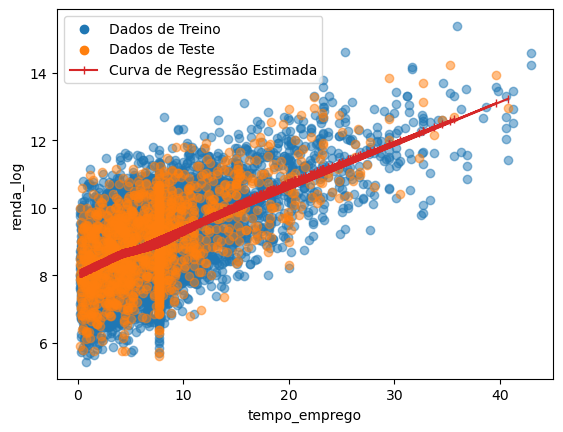

CPU times: user 498 ms, sys: 39.4 ms, total: 537 ms
Wall time: 453 ms


In [17]:
%%time

# Obtendo as cores padrão para os gráficos a partir das configurações do Matplotlib
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Criando um gráfico de dispersão para os dados de treino
plt.scatter(x=df_train.tempo_emprego, y=df_train.renda_log, color=colors[0], alpha=.5)
plt.scatter([], [], color=colors[0], label="Dados de Treino")  # Adicionando uma entrada na legenda para os dados de treino

# Criando um gráfico de dispersão para os dados de teste
plt.scatter(x=df_test.tempo_emprego, y=df_test.renda_log, color=colors[1], alpha=.5)
plt.scatter([], [], color=colors[1], label="Dados de Teste")  # Adicionando uma entrada na legenda para os dados de teste

# Adicionando a curva de regressão estimada para os dados de teste
plt.plot(df_test.tempo_emprego, reg_lowess.predict(df_test), "|-", color=colors[3], label="Curva de Regressão Estimada")

# Adicionando rótulos aos eixos
plt.xlabel("tempo_emprego")
plt.ylabel("renda_log")

# Exibindo a legenda e o gráfico
plt.legend()
plt.show()


In [18]:
# Calculando o coeficiente de determinação (R²) para avaliar a qualidade do ajuste do modelo
# O R² indica a proporção da variabilidade dos dados que é explicada pelo modelo
# Utilizando o método r2_score para comparar os valores reais (y_true) com as previsões do modelo (y_pred)
print("{:.2%}".format(r2_score(y_true=df_test.renda_log, y_pred=reg_lowess.predict(df_test))))


37.33%


---

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

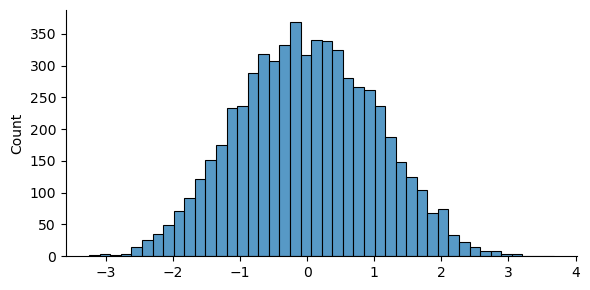

CPU times: user 449 ms, sys: 25.6 ms, total: 474 ms
Wall time: 364 ms


In [21]:
%%time

# Criando um gráfico de distribuição (histograma) dos resíduos do modelo de regressão
# 'reg.resid' contém os resíduos (diferença entre os valores reais e os valores previstos pelo modelo)
sns.displot(data=reg_lowess.resid, height=3, aspect=2)

# Exibindo o gráfico
plt.show()


<!-- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)? -->
> Os resíduos exibidos no histograma parecem seguir uma distribuição aproximadamente normal, já que apresentam um formato simétrico em torno de zero, com a maioria dos valores concentrados perto da média e caindo gradualmente nas extremidades. Esse padrão é típico de uma distribuição normal.

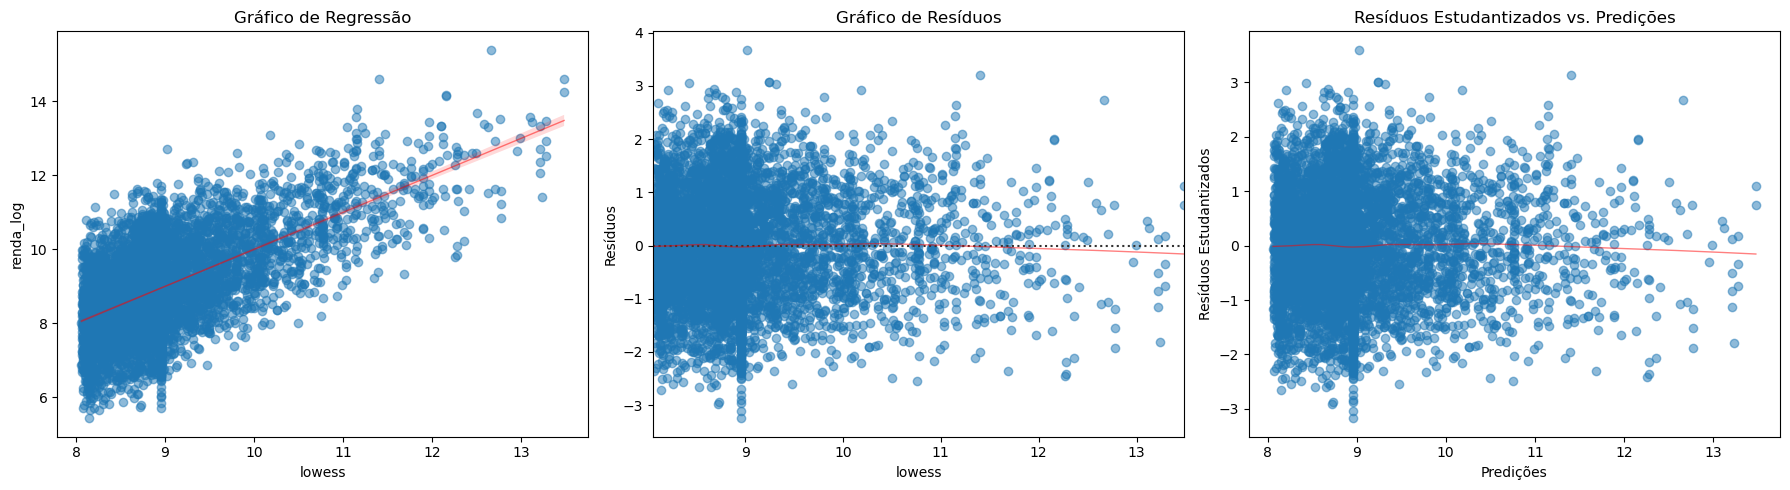

CPU times: user 15.9 s, sys: 1.06 s, total: 17 s
Wall time: 10.2 s


In [23]:
%%time

# Verificando a suposição de independência dos resíduos através de 3 gráficos: 
# Gráfico de Regressão, Gráfico de Resíduos e Gráfico de Resíduos Estudantizados vs. Predições

fig, ax = plt.subplots(ncols=3, figsize=(18,5))

# Gráfico de Regressão entre 'lowess' e 'renda_log'
sns.regplot(ax=ax[0], 
            data=df_train, 
            x="lowess", 
            y="renda_log", 
            scatter_kws={"alpha":.5},  # Transparência para os pontos
            line_kws={"color":"red", "lw":1, "alpha":.5})  # Linha de regressão vermelha

ax[0].set_title("Gráfico de Regressão")
ax[0].set_xlabel("lowess")
ax[0].set_ylabel("renda_log")

# Gráfico de Resíduos entre 'lowess' e 'renda_log'
sns.residplot(ax=ax[1], 
              data=df_train, 
              x="lowess", 
              y="renda_log", 
              lowess=True,  # Suavização para destacar a tendência dos resíduos
              scatter_kws={"alpha":.5}, 
              line_kws={"color":"red", "lw":1, "alpha":.5})

ax[1].set_title("Gráfico de Resíduos")
ax[1].set_xlabel("lowess")
ax[1].set_ylabel("Resíduos")

# Gráfico de Resíduos Estudantizados vs. Predições
sns.regplot(ax=ax[2], 
            x=reg_lowess.predict(),  # Predições do modelo
            y=reg_lowess.outlier_test().student_resid,  # Resíduos estudantizados
            scatter_kws={"alpha":.5}, 
            line_kws={"color":"red", "lw":1, "alpha":.5}, 
            lowess=True)

ax[2].set_title("Resíduos Estudantizados vs. Predições")
ax[2].set_xlabel("Predições")
ax[2].set_ylabel("Resíduos Estudantizados")

# Ajusta o layout dos gráficos para evitar sobreposição
plt.tight_layout()
plt.show()


In [24]:
# Realizando uma regressão linear múltipla
# Variável dependente: 'renda_log'
# Variáveis independentes: 'lowess', 'tipo_renda' e 'posse_de_imovel'
reg_multi = smf.ols(formula="renda_log ~ lowess + tipo_renda + posse_de_imovel", data=df_train).fit()

# Exibindo o resumo dos resultados da regressão
reg_multi.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     618.9
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:50:20   Log-Likelihood:                -8581.8
No. Observations:                6000   AIC:                         1.718e+04
Df Residuals:                    5993   BIC:                         1.722e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.0651      0.156     -0.418      0.676      -0.370       0.240
tipo_renda[T.Bolsista]            -0.6114      0.585     -1.046      0.296      -1.758       0.535
tipo_renda[T.Empresário]           0.1460      0.033      4.423      0.000       0.081       0.211
tipo_renda[T.Pensionista]         -0.2318      0.037     -6.270      0.000      -0.304      -0.159
tipo_renda[T.Servidor público]     0.1935      0.048      4.064      0.000       0.100       0.287
posse_de_imovel[T.S]               0.2034      0.028      7.345      0.000       0.149       0.258
lowess                             0.9910      0.017     58.360      0.000       0.958       1.024
==============================================================================
Omnibus:                       45.465   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.333
Skew:                           0.033   Prob(JB):                     1.57e-07
Kurtosis:                       2.652   Cond. No.                         410.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
%%time 

# Realizando um teste de identificação de outliers no modelo ajustado
# A função outlier_test() avalia a influência dos pontos nos resultados do modelo, incluindo resíduos estudantizados e p-valores associados
outlier_test = reg_multi.outlier_test()


CPU times: user 24.3 s, sys: 1.71 s, total: 26 s
Wall time: 13.5 s


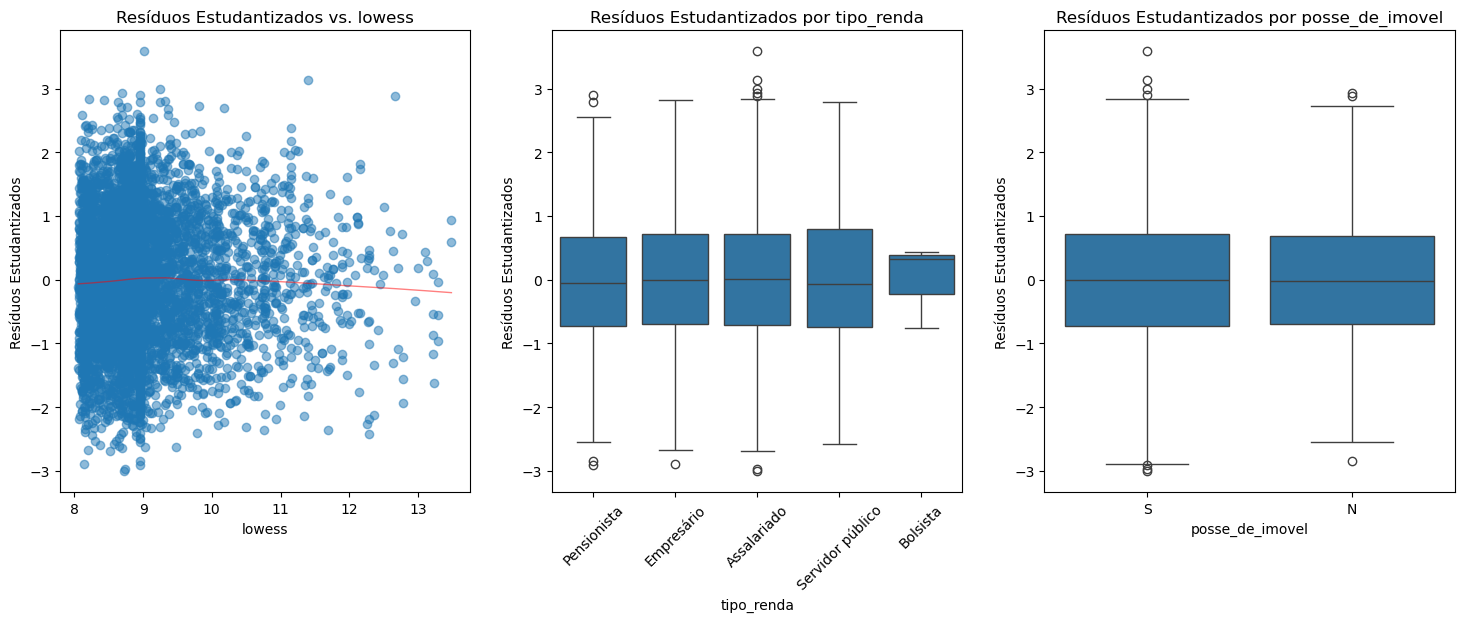

CPU times: user 1.72 s, sys: 44.2 ms, total: 1.76 s
Wall time: 1.66 s


In [26]:
%%time

# Criando uma figura com três gráficos para analisar os resíduos estudantizados em relação às diferentes variáveis do modelo de regressão múltipla

fig, ax = plt.subplots(ncols=3, figsize=(18,6))

# Gráfico de Dispersão: Resíduos Estudantizados vs. 'lowess'
# Avalia a relação entre resíduos estudantizados e a variável 'lowess'
sns.regplot(ax=ax[0], x=df_train.lowess, y=outlier_test.student_resid, lowess=True, 
            scatter_kws={"alpha":.5}, line_kws={"color":"red", "lw":1, "alpha":.5})

ax[0].set_title("Resíduos Estudantizados vs. lowess")
ax[0].set_xlabel("lowess")
ax[0].set_ylabel("Resíduos Estudantizados")

# Gráfico de Boxplot: Resíduos Estudantizados por 'tipo_renda'
# Mostra a distribuição dos resíduos estudantizados para cada categoria de 'tipo_renda'
sns.boxplot(ax=ax[1], x=df_train.tipo_renda, y=outlier_test.student_resid)
ax[1].set_title("Resíduos Estudantizados por tipo_renda")
ax[1].set_xlabel("tipo_renda")
ax[1].set_ylabel("Resíduos Estudantizados")
ax[1].tick_params(axis="x", rotation=45)  # Rotaciona os rótulos do eixo x para melhor legibilidade

# Gráfico de Boxplot: Resíduos Estudantizados por 'posse_de_imovel'
# Mostra a distribuição dos resíduos estudantizados para cada categoria de 'posse_de_imovel'
sns.boxplot(ax=ax[2], x=df_train.posse_de_imovel, y=outlier_test.student_resid)
ax[2].set_title("Resíduos Estudantizados por posse_de_imovel")
ax[2].set_xlabel("posse_de_imovel")
ax[2].set_ylabel("Resíduos Estudantizados")

# Exibindo os gráficos
plt.show()


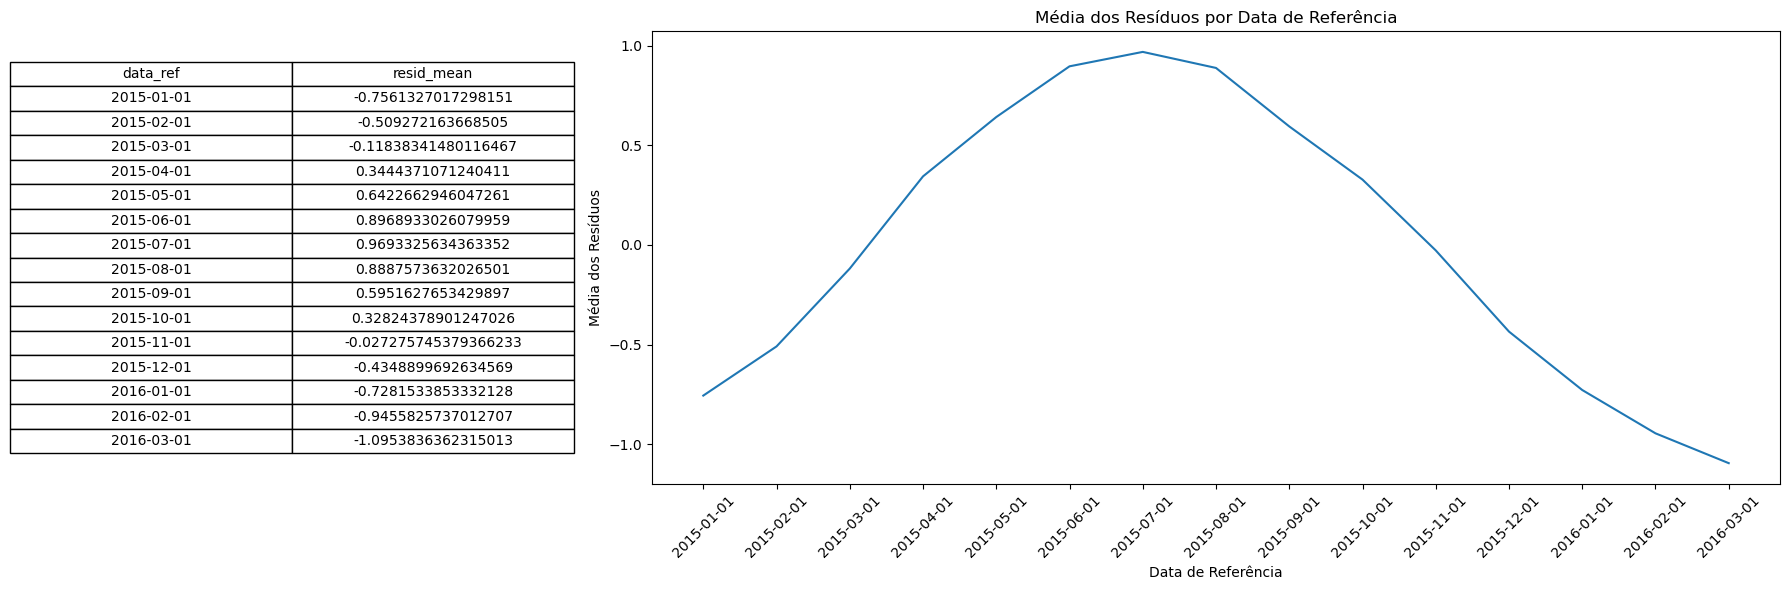

In [27]:
# Avaliando se o valor médio dos resíduos aparenta ter relação com o mês de referência

# Merge para criar o DataFrame df_resid com os resíduos associados à data de referência
df_resid = pd.merge(left=df_train[["data_ref"]], right=pd.Series(data=reg_multi.resid, name="resid"), left_index=True, right_index=True, how="left")

# Preparar os dados para a tabela: calcular a média dos resíduos por data de referência
df_resid_mean = df_resid.groupby(by="data_ref")["resid"].mean().reset_index().rename(columns={"resid":"resid_mean"})

# Criação do layout com plt.subplots() para exibir a tabela e o gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={"width_ratios": [1, 2]})

# Exibir a tabela de médias dos resíduos à esquerda
ax1.axis("off")  # Desativa o eixo
table = ax1.table(cellText=df_resid_mean.values, colLabels=df_resid_mean.columns, cellLoc="center", loc="center")
table.scale(1,1.5)  # Ajusta o tamanho da tabela
table.auto_set_font_size(False)
table.set_fontsize(10)

# Criar o gráfico de linha à direita para mostrar a média dos resíduos ao longo do tempo
sns.lineplot(data=df_resid_mean, x="data_ref", y="resid_mean", ax=ax2)
ax2.set_title("Média dos Resíduos por Data de Referência")
ax2.set_xlabel("Data de Referência")
ax2.set_ylabel("Média dos Resíduos")
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor legibilidade

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()


<!-- Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios? -->
> As suposições do modelo não estão totalmente atendidas. Observamos o seguinte:  
> 1. **Distribuição dos Resíduos**: Os resíduos (diferença entre valores reais e previstos) têm uma forma que sugere uma distribuição normal, o que é bom.  
> 2. **Gráfico de Resíduos**: A dispersão dos resíduos mostra alguns problemas. Parece que a variância dos resíduos não é constante em todas as predições, o que pode indicar heterocedasticidade (variação não constante).  
> 3. **Relação com a Data de Referência**: Existe uma relação clara entre os resíduos e a data de referência. Isso sugere que o modelo não está capturando bem a variação temporal, o que pode afetar a precisão das previsões.  
>> Em resumo, o modelo pode precisar de ajustes para lidar melhor com a variação ao longo do tempo e para garantir que a variância dos resíduos seja constante.

---

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

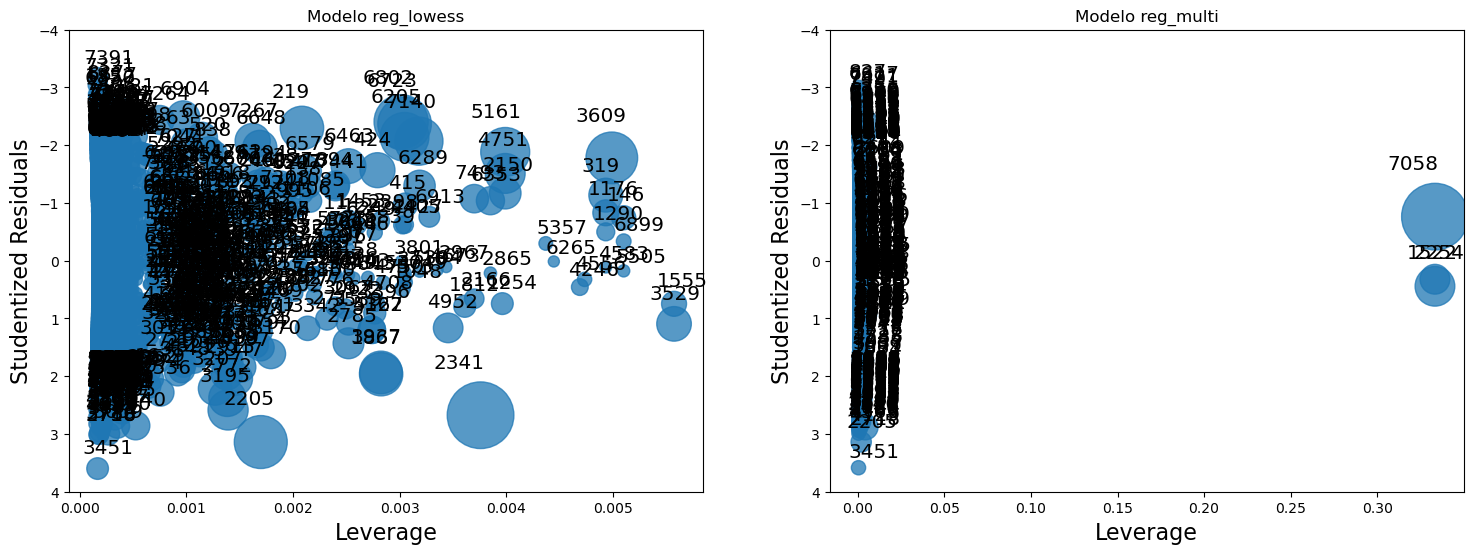

In [31]:
# Avaliando os resíduos estudantizados e identificando pontos discrepantes ou influentes

# Criando uma figura com dois gráficos para analisar a influência dos pontos no modelo de regressão
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

# Gráfico de influência para o modelo de regressão 'reg', usando o critério de Cook's Distance
sm.graphics.influence_plot(results=reg_lowess, criterion="cooks", ax=ax[0])
ax[0].set_title("Modelo reg_lowess")
# Ajustando os limites do eixo y para alinhar com a escala dos resíduos estudantizados internos
ax[0].set_ylim(np.ceil(np.max(reg_lowess.get_influence().resid_studentized_internal)), np.floor(np.min(reg_lowess.get_influence().resid_studentized_internal)))

# Gráfico de influência para o modelo 'reg_multi', usando o critério de Cook's Distance
sm.graphics.influence_plot(results=reg_multi, criterion="cooks", ax=ax[1])
ax[1].set_title("Modelo reg_multi")
# Ajustando os limites do eixo y para alinhar com a escala dos resíduos estudantizados internos
ax[1].set_ylim(np.ceil(np.max(reg_multi.get_influence().resid_studentized_internal)), np.floor(np.min(reg_multi.get_influence().resid_studentized_internal)))

# Exibindo os gráficos
plt.show()


In [32]:
%%time

# Exibindo a contagem de observações para cada combinação de 'tipo_renda' e 'posse_de_imovel' no DataFrame de treino
# Isso ajuda a entender a distribuição das observações por essas categorias
display(df_train.groupby(["tipo_renda", "posse_de_imovel"]).size().to_frame(name="qtd"))

# Calculando a alavancagem (leverage) para cada observação com base no modelo de regressão múltipla
# A alavancagem mede o impacto potencial de cada observação na estimativa dos parâmetros do modelo
df_train["leverage"] = reg_multi.get_influence().hat_matrix_diag

# Exibindo as observações com alavancagem maior que 0.2
# Essas observações têm um impacto potencialmente alto na estimação dos parâmetros do modelo
display(df_train[df_train.leverage > .2])

# Exibindo a contagem de observações com alta alavancagem para cada combinação de 'tipo_renda' e 'posse_de_imovel'
# Isso fornece uma visão detalhada da distribuição das observações com alta alavancagem por categoria
display(df_train[df_train.leverage > .2].groupby(by=["tipo_renda", "posse_de_imovel"]).size().to_frame("qtd"))


qtd
tipo_renda       posse_de_imovel      
Assalariado      N                1112
                 S                1980
Bolsista         S                   3
Empresário       N                 456
                 S                 909
Pensionista      N                 257
                 S                 743
Servidor público N                 210
                 S                 330

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,lowess,leverage
1522,2015-04-01,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,10200.21,9.230164,9.421858,0.333333
2254,2015-05-01,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,9221.76,9.129321,9.421858,0.333333
7058,2016-03-01,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,3766.03,8.233777,9.421858,0.333333


,,qtd
tipo_renda,posse_de_imovel,
Bolsista,S,3


CPU times: user 43.5 ms, sys: 4.42 ms, total: 47.9 ms
Wall time: 53.4 ms


In [33]:
%%time

# Filtrando os dados para remover as observações onde 'tipo_renda' é igual a 'Bolsista'
# Cria cópias dos DataFrames de treino e teste sem as observações de 'Bolsista'
df_train = df_train[df_train["tipo_renda"] != "Bolsista"].copy()
df_test = df_test[df_test["tipo_renda"] != "Bolsista"].copy()

# Calculando os resíduos estudantizados para o DataFrame de treino com base no modelo 'reg_multi'
df_train["student_resid"] = outlier_test.student_resid

# Filtrando os dados para remover observações com resíduos estudantizados fora do intervalo [-2, 2]
# Isso ajuda a eliminar possíveis outliers
df_train = df_train[(df_train["student_resid"] < 2) & (df_train["student_resid"] > -2)]

# Exibindo as dimensões dos DataFrames de treino e teste após a filtragem
print(df_train.shape)  # Tamanho do DataFrame de treino
print(df_test.shape)   # Tamanho do DataFrame de teste


(5759, 17)
(1500, 15)
CPU times: user 13.9 ms, sys: 3.67 ms, total: 17.6 ms
Wall time: 19.1 ms


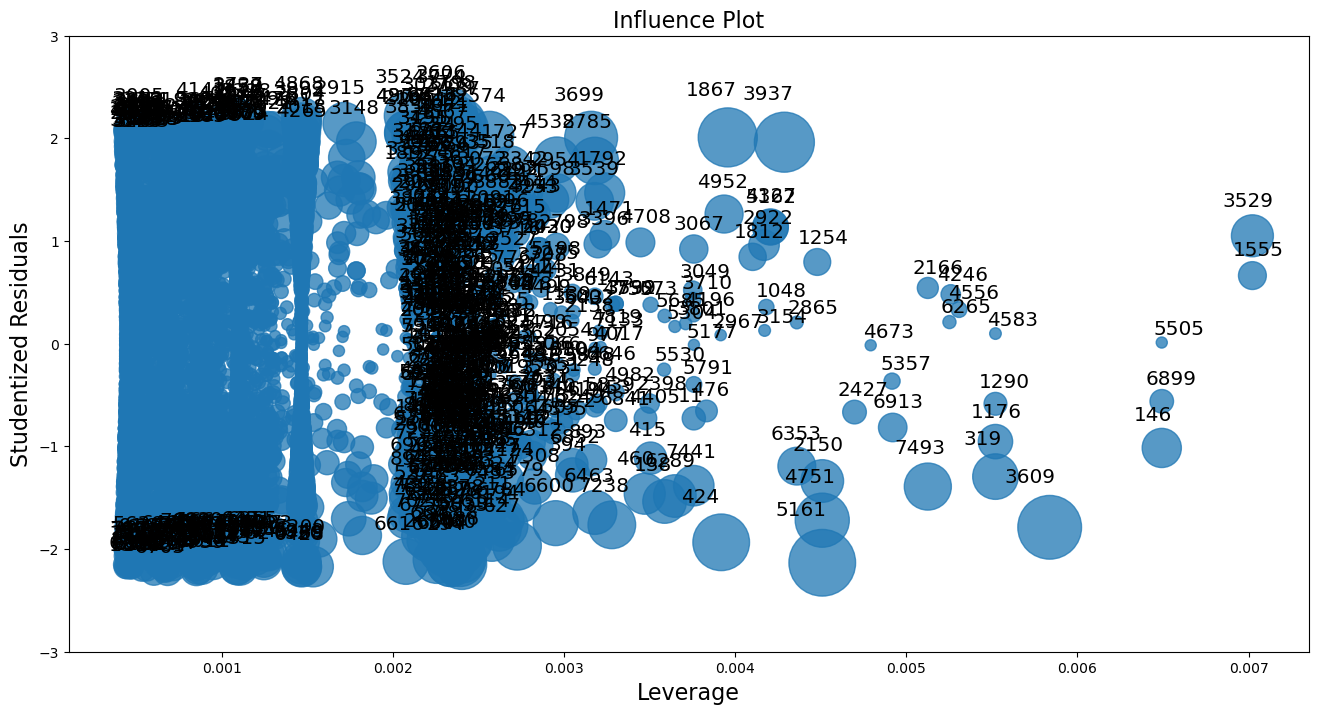

CPU times: user 23.5 s, sys: 1.61 s, total: 25.1 s
Wall time: 14.6 s


In [34]:
%%time

# Criando uma figura com um gráfico para analisar a influência dos pontos no modelo de regressão múltipla
fig, ax = plt.subplots(figsize=(16,8))

# Criando o gráfico de influência para o modelo de regressão múltipla utilizando o critério de Cook's Distance para identificar pontos discrepantes ou influentes
# Os dados utilizados são do DataFrame de treino após a filtragem
sm.graphics.influence_plot(results=smf.ols(formula="renda_log ~ lowess + tipo_renda + posse_de_imovel", data=df_train).fit(), criterion="cooks", ax=ax)

# Ajustando os limites do eixo y para focar na faixa de influência de -3 a 3
plt.ylim(-3, 3)

# Exibindo o gráfico
plt.show()


---

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

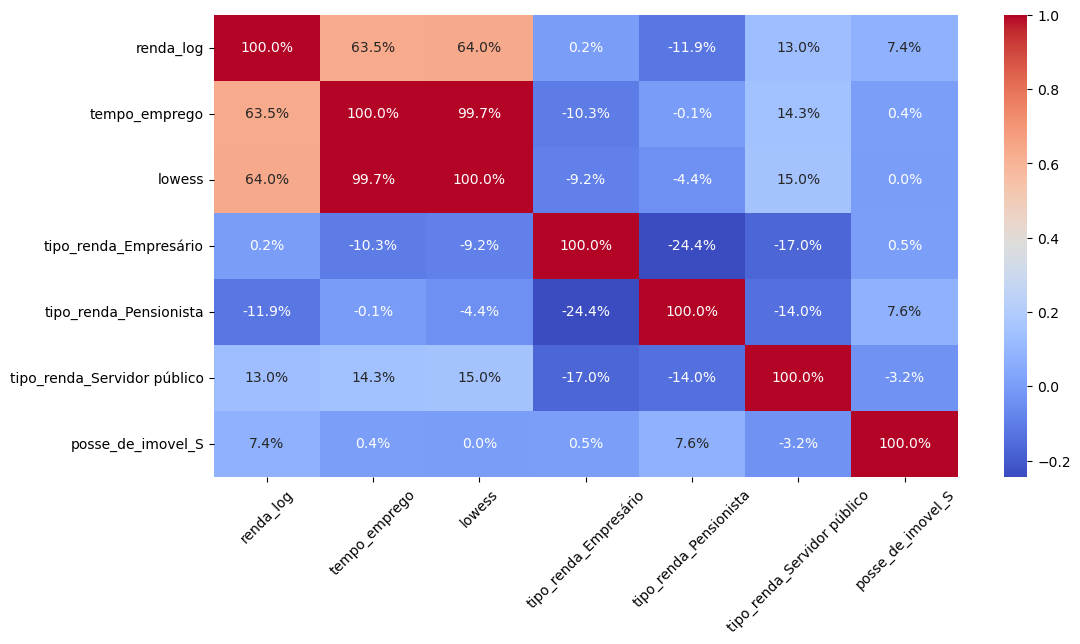

In [37]:
# Criando a matriz de correlação de Pearson para variáveis selecionadas

plt.figure(figsize=(12, 6))  # Define o tamanho da figura

# Calcula a correlação de Pearson entre as variáveis selecionadas
# pd.get_dummies transforma variáveis categóricas em variáveis binárias (dummy variables)
# O método 'corr' calcula a matriz de correlação de Pearson
sns.heatmap(pd.get_dummies(data=df_train[["renda_log", "tempo_emprego", "lowess", "tipo_renda", "posse_de_imovel"]], drop_first=True).corr(method="pearson"),
            annot=True,  # Exibe os valores de correlação dentro do gráfico
            fmt=".1%",  # Formata os valores de correlação como porcentagens
            cmap="coolwarm")  # Define o mapa de cores 'coolwarm' para destacar correlações positivas e negativas

# Rotaciona os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Exibe o gráfico de calor (heatmap) com a matriz de correlação
plt.show()


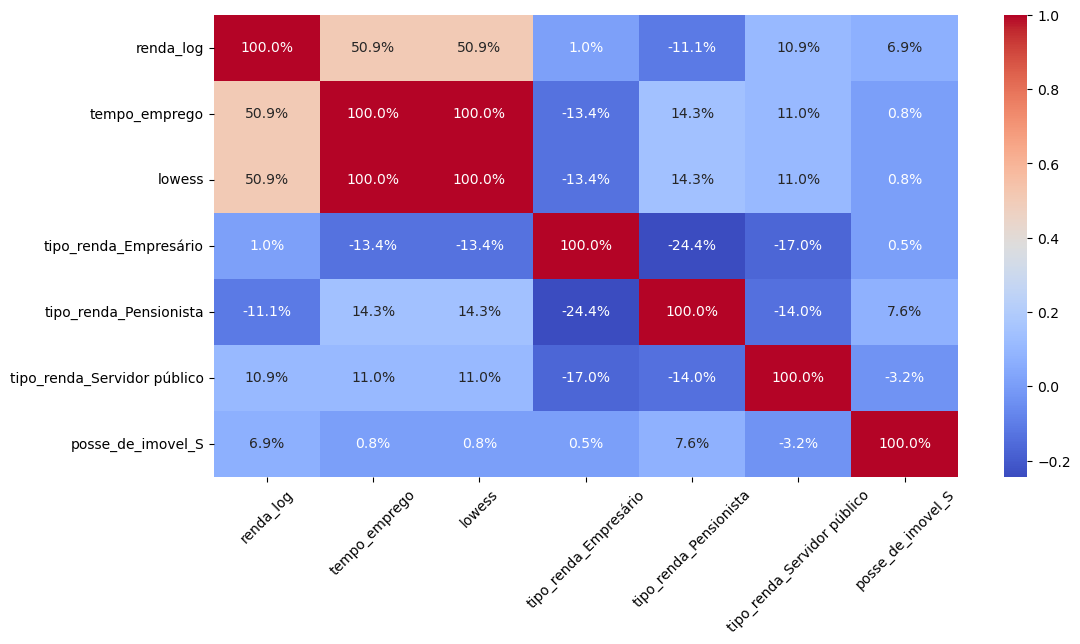

In [38]:
# Criando a matriz de correlação de Spearman para variáveis selecionadas

plt.figure(figsize=(12, 6))  # Define o tamanho da figura

# Calcula a correlação de Spearman entre as variáveis selecionadas
# pd.get_dummies transforma variáveis categóricas em variáveis binárias (dummy variables)
# O método 'corr' calcula a matriz de correlação de Spearman
sns.heatmap(pd.get_dummies(data=df_train[["renda_log", "tempo_emprego", "lowess", "tipo_renda", "posse_de_imovel"]], drop_first=True).corr(method="spearman"),
            annot=True,  # Exibe os valores de correlação dentro do gráfico
            fmt=".1%",  # Formata os valores de correlação como porcentagens
            cmap="coolwarm")  # Define o mapa de cores 'coolwarm' para destacar correlações positivas e negativas

# Rotaciona os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Exibe o gráfico de calor (heatmap) com a matriz de correlação de Spearman
plt.show()


In [39]:
# Calculando o Fator de Inflação da Variância (VIF) para detectar multicolinearidade

# Definindo as colunas para as quais o VIF será calculado
columns = ["tempo_emprego", "posse_de_imovel", "tipo_renda"]

# Criando variáveis dummies para as variáveis categóricas
df_train_dummies = pd.get_dummies(data=df_train[columns], drop_first=True, dtype=int)

# Criando um DataFrame vazio para armazenar os valores de VIF e os nomes das features
df_vif = pd.DataFrame()

# Calculando o VIF para cada variável independente no DataFrame de treino transformado em dummies
df_vif["VIF Factor"] = [vif(df_train_dummies, i) for i in range(df_train_dummies.shape[1])]

# Adicionando uma coluna com os nomes das features
df_vif["Feature"] = df_train_dummies.columns

# Exibindo o DataFrame com os fatores de VIF arredondados para duas casas decimais
df_vif.round(2)


,VIF Factor,Feature
0,1.90,tempo_emprego
1,1.99,posse_de_imovel_S
2,1.26,tipo_renda_Empresário
3,1.25,tipo_renda_Pensionista
4,1.16,tipo_renda_Servidor público


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

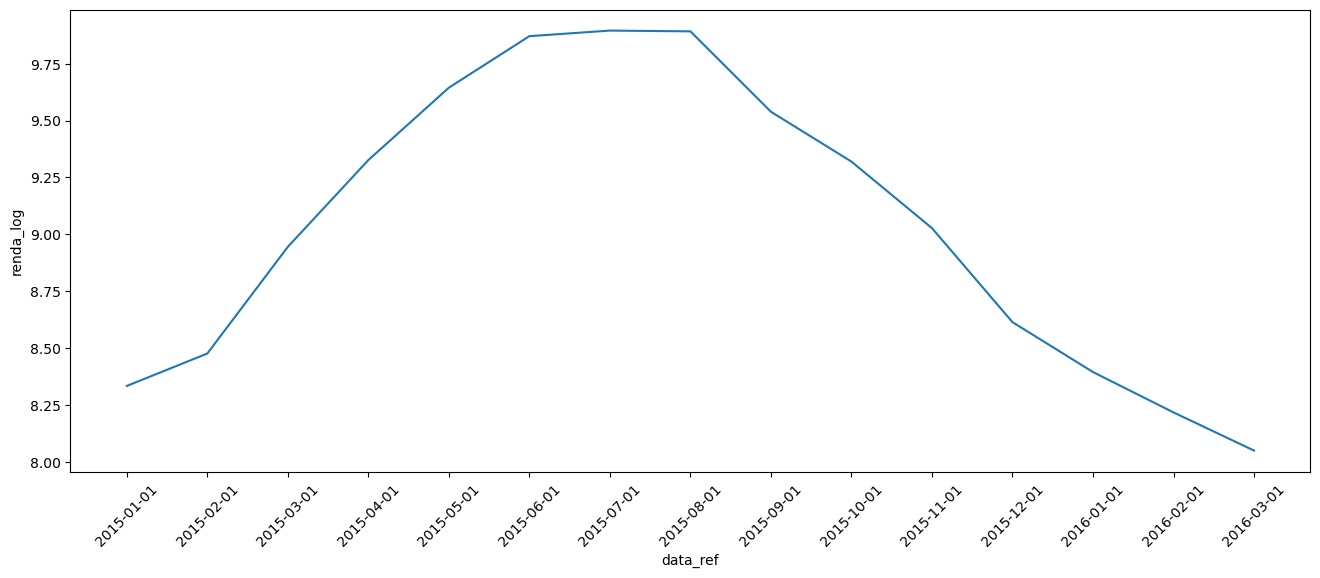

In [41]:
# Criando um gráfico de linha para mostrar a média de 'renda_log' ao longo do tempo (data_ref)

plt.figure(figsize=(16,6))  # Define o tamanho da figura

# Agrupa os dados de treino por 'data_ref' e calcula a média de 'renda_log' para cada data
sns.lineplot(data=df_train.groupby(by="data_ref").renda_log.mean())

# Rotaciona os rótulos do eixo x para que as datas fiquem mais legíveis
plt.xticks(rotation=45)

# Exibe o gráfico
plt.show()


In [42]:
# Ajustando 'renda_log' para remover a influência da variável 'data_ref'
# Subtrai a média de 'renda_log' para cada data de referência ('data_ref') de cada valor individual de 'renda_log'
# O objetivo é ajustar a variável 'renda_log' sem a influência de 'data_ref', conforme avaliado no gráfico anterior

df_train["renda_log_data_ref"] = df_train.renda_log - df_train.data_ref.map(df_train["renda_log"].groupby(by=df_train.data_ref).mean())

# Exibindo o DataFrame com a nova coluna 'renda_log_data_ref' que representa 'renda_log' ajustada
df_train


,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,lowess,leverage,student_resid,renda_log_data_ref
543,2015-02-01,F,N,S,0,Pensionista,Médio,Casado,Casa,65,7.666518,2.0,2468.74,7.811463,8.959169,0.001049,-0.963003,-0.664801
1526,2015-04-01,F,N,S,1,Empresário,Médio,Solteiro,Casa,31,1.783562,2.0,5960.13,8.692848,8.296036,0.000920,0.184630,-0.633531
4680,2015-10-01,F,N,S,0,Assalariado,Superior completo,Separado,Casa,41,9.016438,1.0,21684.23,9.984341,9.154541,0.000423,0.764383,0.664663
6868,2016-02-01,F,N,S,0,Pensionista,Médio,Casado,Casa,61,7.666518,2.0,2433.88,7.797242,8.959169,0.001049,-0.977064,-0.420302
891,2015-02-01,F,N,S,0,Assalariado,Médio,Casado,Casa,44,15.936986,2.0,6074.95,8.711929,10.209409,0.000793,-1.526836,0.235665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,2015-10-01,F,N,S,0,Assalariado,Médio,Casado,Casa,47,6.830137,2.0,5298.50,8.575179,8.870658,0.000430,-0.350230,-0.744499
4671,2015-10-01,M,S,S,0,Pensionista,Médio,Casado,Casa,58,7.666518,2.0,13043.06,9.476011,8.959169,0.001049,0.682606,0.156333
4486,2015-09-01,F,N,S,0,Assalariado,Superior completo,Viúvo,Casa,47,0.389041,1.0,2825.32,7.946377,8.087538,0.000686,-0.204678,-1.592377
5192,2015-11-01,F,N,S,0,Empresário,Médio,Casado,Casa,53,4.797260,2.0,6944.02,8.845636,8.699864,0.000828,-0.059945,-0.181672


In [43]:
# Realizando uma nova regressão linear múltipla ajustada
# A variável dependente é 'renda_log_data_ref', que representa 'renda_log' ajustada para remover o efeito da 'data_ref'
# As variáveis independentes são: 'tempo_emprego', 'C(tipo_renda)' (variável categórica codificada como dummy), e 'C(posse_de_imovel)' (outra variável categórica codificada como dummy)

reg_ajuste = smf.ols(formula="renda_log_data_ref ~ tempo_emprego + C(tipo_renda) + C(posse_de_imovel)", data=df_train).fit()

# Exibindo o resumo dos resultados da nova regressão ajustada
reg_ajuste.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     renda_log_data_ref   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     1510.
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:51:19   Log-Likelihood:                -5970.5
No. Observations:                5759   AIC:                         1.195e+04
Df Residuals:                    5753   BIC:                         1.199e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.1245      0.021    -53.227      0.000      -1.166      -1.083
C(tipo_renda)[T.Empresário]           0.1349      0.023      5.946      0.000       0.090       0.179
C(tipo_renda)[T.Pensionista]         -0.2835      0.025    -11.167      0.000      -0.333      -0.234
C(tipo_renda)[T.Servidor público]     0.1440      0.033      4.370      0.000       0.079       0.209
C(posse_de_imovel)[T.S]               0.2045      0.019     10.720      0.000       0.167       0.242
tempo_emprego                         0.1291      0.002     83.726      0.000       0.126       0.132
==============================================================================
Omnibus:                       17.273   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.693
Skew:                          -0.017   Prob(JB):                      0.00106
Kurtosis:                       2.764   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# Calcula a média de 'renda_log' para cada 'data_ref' no DataFrame de treino
data_map = df_train.renda_log.groupby(df_train.data_ref).mean()

# Estima os valores de 'renda_log' para o DataFrame de teste
# Adiciona a previsão da regressão ajustada à média de 'renda_log' por 'data_ref'
renda_log_pred = df_test.data_ref.map(data_map) + reg_ajuste.predict(df_test)

# Calcula o coeficiente de determinação (R²) para avaliar o desempenho do modelo ajustado
r2 = r2_score(y_true=df_test.renda_log, y_pred=renda_log_pred)

# Exibe o R² como uma porcentagem
print("{:.2%}".format(r2))


67.50%


---